## Flow Matching

In the previous notebooks, we explored diffusion models that work by gradually removing noise at each step. While effective, this process is inherently stochastic and can be slow, requiring many steps to generate high-quality samples.

**Flow Matching** offers an alternative approach that enforces a smooth, deterministic trajectory from noise to data. Instead of learning to denoise at discrete timesteps, we learn a **vector field** that defines a continuous path, that we call Continuous Normalizing Flow (CNF).
Let's take a look at this image, notice the intuitive difference between the trajectory in the diffusion case vs flow based models:

<figure style="text-align: center;">
  <img src="./images/flow_vs_diffusion.png" alt="My Image" width="400">
  <figcaption>Visualization by Alec Helbling, <a href="https://github.com/helblazer811/Diffusion-Explorer">check his repo!</a></figcaption>
</figure>
The key insight is elegant: rather than predicting noise to remove, we predict the **velocity** at each point along the path. Given a probability path $p_t$ that smoothly transitions from noise $p_0$ to data $p_1$, we define a vector field $v_t(x)$ that guides particles along this path. The model's job is to learn this velocity vector $v_t(x,t)$ at any given point $x$ and time $t$.

In this notebook, we'll:
- Understand the mathematical foundation of flow matching
- Implement a simple straight-line path from noise to data
- Train a model to predict velocities along this path
- Generate images using the learned flow
- Apply flow matching to conditional generation

The beauty of flow matching lies in its simplicity: by choosing a straight-line interpolation path, the velocity becomes constant and easy to learn, while still producing high-quality results! 



In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.utils as vutils
import torchvision.transforms as transforms

### Step 1: Understanding Vector Fields and ODEs

Before diving into flow matching, let's build intuition with a simple example. Imagine we want to move a particle from some starting point toward the origin (0, 0). We can define a vector field that points toward the origin at every location.

The **Euler method** is a simple numerical technique to solve ordinary differential equations (ODEs). Given a velocity field $v(x)$, we can trace a path by repeatedly taking small steps: $x_{t+dt} = x_t + v(x_t) \cdot dt$.

In the example below, we'll visualize how a particle moves along a vector field that always points toward the origin. This demonstrates the core idea: given a velocity field, we can integrate it to find trajectories.


In [ ]:
def euler_solve(x_start, n_steps):
    x_values = [x_start.clone()]
    # Velocity proportional to -x
    v = -x_start
    dt = 1/n_steps
    x = x_start.clone()
    # Euler integration loop
    for i in range(n_steps):
        x = x + v*dt
        x_values.append(x.clone())
        v = -x
    return x_values


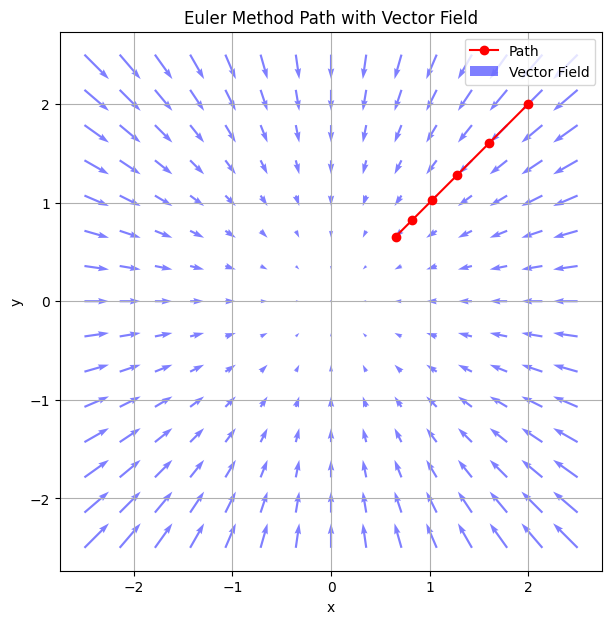

In [ ]:
def plot_path(x_start, n_steps):
    path = euler_solve(x_start, n_steps)

    # plot the path and show direction over time
    x_vals = [p[0].item() for p in path]
    y_vals = [p[1].item() for p in path]

    plt.figure(figsize=(7, 7))
    plt.plot(x_vals, y_vals, marker='o', color='red', label='Path')  # Make the path red

    # Show direction with an arrow every N steps (e.g., every 10 steps)
    N = 10
    for i in range(0, len(path) - N, N):
        dx = x_vals[i + N] - x_vals[i]
        dy = y_vals[i + N] - y_vals[i]
        plt.arrow(x_vals[i], y_vals[i], dx, dy, head_width=0.05, head_length=0.1, fc='r', ec='r')

    # Visualize the vector field (arrows pointing to the center)
    grid_size = 15
    range_val = 2.5
    X, Y = np.meshgrid(
        np.linspace(-range_val, range_val, grid_size),
        np.linspace(-range_val, range_val, grid_size)
    )
    U = -X
    V = -Y
    plt.quiver(X, Y, U, V, color='b', alpha=0.5, label="Vector Field")

    plt.title('Euler Method Path with Vector Field')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.axis('equal')
    plt.grid(True)

# Resulting path starting from point (2,2)
x_start = torch.tensor([2.0,2.0])
n_steps = 5
plot_path(x_start, n_steps)

### The Straight-Line Path

The visualization above shows how particles follow a vector field. In flow matching, we want to learn a vector field that transports noise to data. The simplest choice is a **straight-line path** between noise and data.

For each data point $x_1$ and noise point $x_0$, we define the path as a simple linear interpolation:
$$x_t = (1-t) \cdot x_0 + t \cdot x_1$$

where $t \in [0, 1]$ parameterizes the path from noise ($t=0$) to data ($t=1$). This is the most straightforward probability path we can use, and it turns out to work remarkably well!


### Step 2: Computing the Target Velocity

Now that we've defined our path, we need to compute what velocity the model should predict. Since we're using a straight-line path, the velocity is simply the derivative with respect to time:

$$\frac{d}{dt}x_t = \frac{d}{dt}[(1-t) \cdot x_0 + t \cdot x_1] = x_1 - x_0$$

This is beautifully simple: the velocity is constant along the entire path! The model just needs to learn to predict $x_1 - x_0$ given any point $x_t$ along the path and the time $t$.

This makes the training objective straightforward: sample a random time $t$, interpolate between noise and data to get $x_t$, and train the model to predict the constant velocity $x_1 - x_0$.


The loss function implements exactly what we described: for each data sample $x_1$, we sample noise $x_0$, a random time $t$, compute the interpolated point $x_t$, and train the model to predict the target velocity $x_1 - x_0$.


In [ ]:
def compute_flow_match_loss(model, x_1):
    # x_1: Real data batch (Batch, C, H, W)
    b = x_1.shape[0]
    
    # 1. Sample x_0 (Pure Gaussian Noise)
    x_0 = torch.randn_like(x_1)
    
    # 2. Sample random time t (uniform 0 to 1)
    # Make sure to reshape it to (B, 1, 1, 1) for broadcasting!
    t = torch.rand((b,), device=x_1.device)
    t_broad = t.view(-1, 1, 1, 1)
    
    # 3. Compute x_t (Linear Interpolation)
    x_t = (1-t_broad) * x_0 + t_broad * x_1
    
    # 4. Compute Target Velocity (The formula you derived)
    target_v = x_1 - x_0
    
    # 5. Predict with model
    # Note: We need to pass 't' (vector) not 't_broad' to the model usually, 
    # depending on your embedding layer. Let's assume 't' is fine.
    pred_v = model(x_t, t)
    
    # 6. MSE Loss
    return torch.nn.functional.mse_loss(pred_v, target_v)

### Sampling from the Flow

Once we've trained a model to predict velocities, generating new samples is straightforward. We start with pure noise $x_0$ and integrate the learned velocity field from $t=0$ to $t=1$:

1. Start with $x_0 \sim \mathcal{N}(0, I)$ (pure noise)
2. For each step from $t=0$ to $t=1$:
   - Query the model to get the predicted velocity $v_t = \text{model}(x_t, t)$
   - Update: $x_{t+dt} = x_t + v_t \cdot dt$ (Euler step)
3. The final $x_1$ should be a sample from the data distribution

This is a deterministic process (unlike diffusion, which has stochastic steps), and often requires fewer steps to generate high-quality samples!


In [ ]:
@torch.no_grad()
def sample_flow_matching(model, n_samples=16, steps=100, device='mps'):
    # 1. Start with pure noise (Batch, C, H, W)
    # Define x (use IMAGE_SIZE from previous parts)
    x = torch.randn(n_samples, 1, IMAGE_SIZE, IMAGE_SIZE, device=device)
    # Define step size dt
    dt = 1.0 / steps
    
    # 2. Loop from t=0 to t=1
    for i in range(steps):
        # Current time t (scalar or vector)
        t = i * dt
        
        # Create a time tensor for the model (Batch size)
        t_batch = torch.full((n_samples,), t, device=device)
        
        # TODO: Get velocity from model
        v = model(x, t_batch)
        
        # TODO: Update x using Euler step
        x = x + v*dt
    return x


## Training the model
We're now going to look at an example of how to train an image generation model with flow matching. The task and the network follow the implementation we used in previous notebooks: we will train a U-Net style model to generate MNIST digits conditioned on labels.

### Reusing Core Components

For our image generation experiment, we'll reuse the same building blocks from the previous notebooks: the sinusoidal time embedding and the U-Net architecture. The key difference is that instead of predicting noise, our U-Net will now predict velocity vectors.


In [ ]:
class SinusoidalEmbedding(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim
        
    def forward(self, t):
            device = t.device
            emb = torch.zeros(t.shape[0], self.embedding_dim, device=device)
            
            for i in range(self.embedding_dim // 2):
                # We ensure the constant is on the correct device too
                const = torch.tensor(10000.0, device=device) 
                omega_i = torch.exp(-(2*i/self.embedding_dim) * torch.log(const))
                
                emb[:, 2*i] = torch.sin(omega_i * t)
                emb[:, 2*i+1] = torch.cos(omega_i * t)
            
            return emb

In [ ]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        
        # 1. First Convolution: Change channels (e.g. 1 -> 32)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()
        
        # 2. Time Projection: Map time to match 'out_ch'
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        
        # 3. Second Convolution: Refine features
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)
        
    def forward(self, x, t):
        # First Conv
        h = self.conv1(x)
        h = self.bn1(h)
        h = self.relu(h)
        
        # Add Time Embedding
        # (Batch, Time_Dim) -> (Batch, Out_Ch) -> (Batch, Out_Ch, 1, 1)
        time_emb = self.time_mlp(t)
        time_emb = time_emb[(..., ) + (None, ) * 2] # Broadcast to 4D
        h = h + time_emb
        
        # Second Conv
        h = self.conv2(h)
        h = self.bn2(h)
        h = self.relu(h)
        
        return h

In [ ]:
class ConditionalUNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Time Embedding
        self.time_mlp = nn.Sequential(
            SinusoidalEmbedding(32),
            nn.Linear(32, 32),
            nn.ReLU()
        )
        
        self.label_embedding = nn.Embedding(10, 32)
        
        # 1. Down Path
        self.down1 = Block(1, 32, 32)
        self.down2 = Block(32, 64, 32)
        self.down3 = Block(64, 128, 32)
        
        self.pool = nn.MaxPool2d(2)
        
        # 2. Bottleneck
        self.bottleneck = Block(128, 256, 32)
        
        # 3. Up Path
        # We separate the Upsampling (ConvTrans) from the Block (Processing)
        
        # Up 1: 4x4 -> 8x8
        self.up_trans1 = nn.ConvTranspose2d(256, 256, 4, 2, 1) 
        self.up1 = Block(256 + 128, 128, 32) # In: Bottle + Skip(x3)
        
        # Up 2: 8x8 -> 16x16
        self.up_trans2 = nn.ConvTranspose2d(128, 128, 4, 2, 1)
        self.up2 = Block(128 + 64, 64, 32)   # In: Prev + Skip(x2)
        
        # Up 3: 16x16 -> 32x32
        self.up_trans3 = nn.ConvTranspose2d(64, 64, 4, 2, 1)
        self.up3 = Block(64 + 32, 32, 32)    # In: Prev + Skip(x1)
        
        # Final projection
        self.final = nn.Conv2d(32, 1, 3, padding=1)

    def forward(self, x, t, label):
        t = self.time_mlp(t)
        label_emb = self.label_embedding(label)
        
        t = t + label_emb
        
        # --- Down Path ---
        x1 = self.down1(x, t)        # (32, 32, 32)
        x_p1 = self.pool(x1)         # (32, 16, 16)
        
        x2 = self.down2(x_p1, t)     # (64, 16, 16)
        x_p2 = self.pool(x2)         # (64, 8, 8)
        
        x3 = self.down3(x_p2, t)     # (128, 8, 8)
        x_p3 = self.pool(x3)         # (128, 4, 4)
        
        # --- Bottleneck ---
        x = self.bottleneck(x_p3, t) # (256, 4, 4)
        
        # --- Up Path ---
        
        # Step 1: Upsample -> Concat -> Process
        x = self.up_trans1(x)                          # (256, 8, 8)
        x = self.up1(torch.cat((x, x3), dim=1), t)     # (128, 8, 8)
        
        # Step 2
        x = self.up_trans2(x)                          # (128, 16, 16)
        x = self.up2(torch.cat((x, x2), dim=1), t)     # (64, 16, 16)
        
        # Step 3
        x = self.up_trans3(x)                          # (64, 32, 32)
        x = self.up3(torch.cat((x, x1), dim=1), t)     # (32, 32, 32)
        
        return self.final(x)

### Conditional Flow Matching

Just like with diffusion models, we can extend flow matching to conditional generation. The conditional loss function is identical to the unconditional version, except we pass the label (digit class) to the model along with the interpolated point and time.

The model learns to associate each label with the corresponding digit's appearance, allowing us to control which digit gets generated.


In [ ]:
def compute_flow_match_loss_conditional(model, x_1, labels):
    # x_1: Real data batch (Batch, C, H, W)
    b = x_1.shape[0]
    
    # 1. Sample x_0 (Pure Gaussian Noise)
    x_0 = torch.randn_like(x_1)
    
    # 2. Sample random time t (uniform 0 to 1)
    # Make sure to reshape it to (B, 1, 1, 1) for broadcasting!
    t = torch.rand((b,), device=x_1.device)
    t_broad = t.view(-1, 1, 1, 1)
    
    # 3. Compute x_t (Linear Interpolation)
    x_t = (1-t_broad) * x_0 + t_broad * x_1
    
    # 4. Compute Target Velocity (The formula you derived)
    target_v = x_1 - x_0
    
    # 5. Predict with model
    # Note: We need to pass 't' (vector) not 't_broad' to the model usually, 
    # depending on your embedding layer. Let's assume 't' is fine.
    pred_v = model(x_t, t, labels)
    
    # 6. MSE Loss
    return torch.nn.functional.mse_loss(pred_v, target_v)

In [ ]:
def load_mnist(image_size=32, batch_size=128, device='cpu'):
    transform = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2) - 1)
    ])
    dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    
    return dataset, dataloader

In [ ]:
IMAGE_SIZE = 32
BATCH_SIZE = 128

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

dataset, dataloader = load_mnist(image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, device=device)

### Training the Flow Matching Model

Let's look at the training look for our Flow Matching model. For each batch:

1. Sample random noise $x_0$ for each data sample $x_1$
2. Sample a random time $t \sim \text{Uniform}(0, 1)$
3. Compute the interpolated point $x_t = (1-t) \cdot x_0 + t \cdot x_1$
4. Compute the target velocity $v_{\text{target}} = x_1 - x_0$
5. Have the model predict the velocity: $v_{\text{pred}} = \text{model}(x_t, t, \text{label})$
6. Minimize the MSE loss: $\mathcal{L} = ||v_{\text{pred}} - v_{\text{target}}||^2$

Notice that we don't need to precompute noise schedules or alpha bars. The model learns to predict velocities along straight-line paths from noise to data.


In [ ]:
# --- 3. Model & Utils ---
model = ConditionalUNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
EPOCHS = 20
# --- 4. Training Loop ---
print("Starting Flow Matching Training...")
model.train()

for epoch in range(EPOCHS):
    epoch_losses = []
    for step, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Calculate Flow Matching Loss
        loss = compute_flow_match_loss_conditional(model, images, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss.item())
        
        if step % 100 == 0:
            print(f"Epoch {epoch} | Step {step} | Loss: {loss.item():.4f}")
            
    print(f"Epoch {epoch} Avg Loss: {sum(epoch_losses)/len(epoch_losses):.4f}")

### Generating Images with Flow Matching

Now let's generate images using our trained model. The sampling process integrates the learned velocity field:

1. Start with pure noise $x_0$
2. For $N$ steps from $t=0$ to $t=1$:
   - Query the model: $v_t = \text{model}(x_t, t, \text{label})$
   - Update: $x_{t+dt} = x_t + v_t \cdot dt$ where $dt = 1/N$
3. The final $x_1$ is our generated image

One advantage of flow matching is that we can often use fewer steps than diffusion models while still getting good results. Let's try generating with just 3 steps to see how well it works!


In [ ]:
@torch.no_grad()
def sample_flow_matching_conditional(model, labels, steps=100, device='mps'):
    model.eval()
    n_samples = len(labels)
    # 1. Start with pure noise (Batch, C, H, W)
    # Define x (use IMAGE_SIZE from previous parts)
    x = torch.randn(n_samples, 1, IMAGE_SIZE, IMAGE_SIZE, device=device)
    # Define step size dt
    dt = 1.0 / steps
    
    # 2. Loop from t=0 to t=1
    for i in range(steps):
        # Current time t (scalar or vector)
        t = i * dt
        
        # Create a time tensor for the model (Batch size)
        t_batch = torch.full((n_samples,), t, device=device)
        
        # TODO: Get velocity from model
        v = model(x, t_batch, labels)
        
        # TODO: Update x using Euler step
        x = x + v*dt
    return x


In [ ]:
def plot_images(sampled_images, n_steps):
    # plot sampled images
    plt.figure(figsize=(10, 4))
    grid = vutils.make_grid(sampled_images.cpu(), nrow=10, normalize=True, scale_each=True)
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.title(f'Sampled MNIST Digits via Flow Matching, {n_steps} gen steps')
    plt.axis('off')
    plt.show()

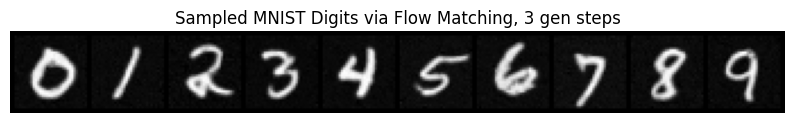

In [ ]:
labels = torch.arange(0, 10).to(device)  # 20 samples (2 of each digit)
n_steps = 3

sampled_images = sample_flow_matching_conditional(model, labels, steps=n_steps, device=device)

Look at the results above: the generated digits have tipically an higher quality, and with a fraction of the generation steps of the traditional DDPM model.

## Final Thoughts

Flow matching represents an elegant alternative to diffusion models, offering several advantages:

**Key Concepts:**
- **Vector Fields**: Instead of learning to denoise, we learn a velocity field that defines smooth trajectories from noise to data
- **Straight-Line Paths**: By using simple linear interpolation, the velocity becomes constant and easy to learn
- **Deterministic Generation**: Unlike diffusion's stochastic steps, flow matching uses deterministic ODE integration
- **Fewer Steps**: Often requires fewer integration steps than diffusion models to achieve similar quality

**What Makes This Powerful:**
The mathematical framework is simpler than diffusion: we just need to learn velocities along straight paths. The training objective is straightforward (predict $x_1 - x_0$), and sampling is a simple ODE integration. Yet, this simplicity doesn't sacrifice quality. Flow matching can match or exceed diffusion model performance with fewer steps, as we have seen in the example above.

**Advantages Over Diffusion:**
1. **Faster sampling**: Fewer steps needed for generation
2. **Simpler training**: No need for complex noise schedules
3. **Deterministic**: Reproducible results (though we can add randomness if desired)
4. **Flexible paths**: We can choose different probability paths beyond straight lines

**Next Steps:**
This notebook covered the basics of flow matching with straight-line paths, but there's more to explore:
- **Optimal Transport Paths**: More sophisticated paths that can improve generation quality
- **Rectified Flows**: Variants that use piecewise-linear paths
- **Latent Flow Matching**: Working in compressed latent spaces for efficiency
- **Text-Conditioned Flow Matching**: Extending to text-to-image generation
